In [14]:
# !unzip brain_tumors.zip

In [15]:
# !pip install tensorflow_addons
# !pip install vit_keras

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from keras.models import Model

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow_addons as tfa
from vit_keras import vit

In [17]:
# Set the seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [18]:
# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

In [19]:
# Load the data
data_dir = 'data\\brain_tumors\\brain_tumors'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

In [20]:
# Prepare the dataset
data = []
labels = []
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img = tf.keras.preprocessing.image.load_img(os.path.join(class_dir, img_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        data.append(img_array)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

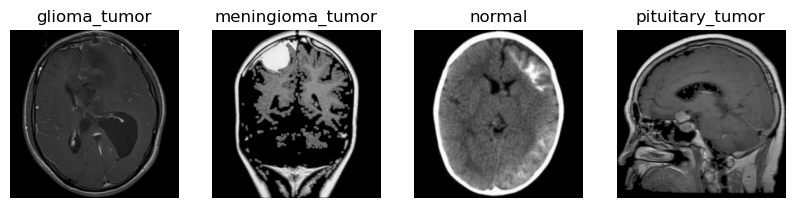

In [21]:
# Plot sample images from each class
plt.figure(figsize=(10, 10))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    sample_image = random.choice(image_files)
    sample_image_path = os.path.join(class_dir, sample_image)
    img = plt.imread(sample_image_path)
    plt.subplot(1, num_classes, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [22]:
# Print the number of images in each class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Number of images in {class_name}: {num_images}")

Number of images in glioma_tumor: 901
Number of images in meningioma_tumor: 913
Number of images in normal: 438
Number of images in pituitary_tumor: 844


In [23]:
# Split the data into training, validation, and testing sets while maintaining class proportions
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [24]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# model

In [25]:
vit_model = vit.vit_b32(
        image_size = IMG_HEIGHT,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes)

353253686/353253686 [==============================] - 82s 0us/step


c:\Users\bruno\Centennial_College\Deep_Learning\Group_Project\deep_learning\conda-env\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [26]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [27]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(num_classes, 'softmax')
    ],
    name = 'vision_transformer')

In [28]:
# Compile the model
model.compile(optimizer=tfa.optimizers.AdamW(
                learning_rate=1e-5, weight_decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# Train the model
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Epoch 1/20
62/62 [==============================] - 169s 3s/step - loss: 1.3517 - accuracy: 0.3783 - val_loss: 1.2139 - val_accuracy: 0.5210
Epoch 2/20
62/62 [==============================] - 153s 2s/step - loss: 1.0271 - accuracy: 0.5965 - val_loss: 0.9162 - val_accuracy: 0.6629
Epoch 3/20
62/62 [==============================] - 150s 2s/step - loss: 0.8122 - accuracy: 0.7101 - val_loss: 0.7048 - val_accuracy: 0.7452
Epoch 4/20
62/62 [==============================] - 147s 2s/step - loss: 0.6726 - accuracy: 0.7864 - val_loss: 0.5490 - val_accuracy: 0.8371
Epoch 5/20
62/62 [==============================] - 148s 2s/step - loss: 0.5531 - accuracy: 0.8288 - val_loss: 0.4739 - val_accuracy: 0.8452
Epoch 6/20
62/62 [==============================] - 157s 3s/step - loss: 0.4564 - accuracy: 0.8843 - val_loss: 0.3902 - val_accuracy: 0.8806
Epoch 7/20
62/62 [==============================] - 189s 3s/step - loss: 0.3893 - accuracy: 0.8975 - val_loss: 0.3404 - val_accuracy: 0.8919
Epoch 8/20
62

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 17s 826ms/step - loss: 0.1943 - accuracy: 0.9468
Test accuracy: 0.9467741847038269


In [31]:
# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

20/20 [==============================] - 19s 753ms/step


In [32]:
# Classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       180
           1       0.92      0.93      0.93       183
           2       0.97      1.00      0.98        88
           3       0.95      0.96      0.96       169

    accuracy                           0.95       620
   macro avg       0.95      0.95      0.95       620
weighted avg       0.95      0.95      0.95       620



In [33]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[166  10   1   3]
 [  5 170   2   6]
 [  0   0  88   0]
 [  2   4   0 163]]


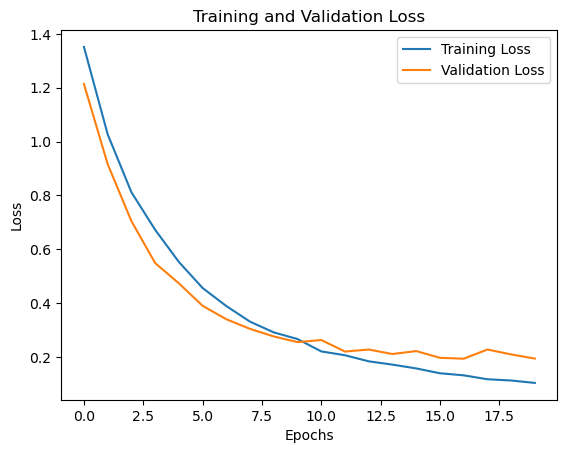

In [34]:
# Loss curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [35]:
# Select five random indices from the test set
random_indices = np.random.choice(len(x_test), 5, replace=False)

In [36]:
# Get the actual and predicted classes for the selected indices
actual_classes = y_test[random_indices]
predicted_classes = y_pred_classes[random_indices]

In [37]:
# Define class labels
class_labels = ["glioma_tumor", "meningioma_tumor", "normal", "pituitary_tumor"]

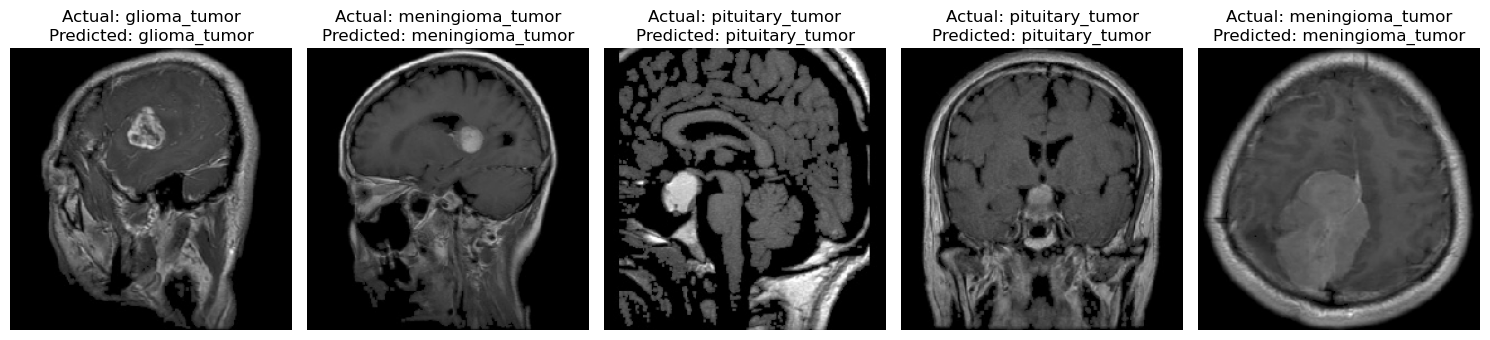

In [38]:
# Plot the images with their actual and predicted classes
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[idx])  # Assuming x_test contains the images
    plt.title(f"Actual: {class_labels[actual_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()